# Fully Connected Network

This notebook contains the implementation of MLP swarm model under steady state conditions.

Importing desired libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import animation
import matplotlib
import time
import sys
import math
from matplotlib import animation, rc, rcParams
from IPython.display import HTML
import time
import csv
from IPython.display import display
from sklearn.model_selection import train_test_split


# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Reading CSV file, which contains the data of the swarms

In [0]:
############## READING CSV ################
# read csv file into position and velocity lists
file_name = '/content/drive/My Drive/CIS522/Final Project/Datasets/swarm_03262020_100000timelag.csv'
my_data = []
with open(file_name) as csvDataFile:
  csvReader = csv.reader(csvDataFile)
  for row in csvReader:
    my_data.append(row)
pos_from_file = []
vel_from_file =[]
pos_line = []
vel_line = []

for i in range(len(my_data)):
  for j in range(int(len(my_data[0])/2)):
    try:
      pos_line_str = my_data[i][j*2].lstrip('[').rstrip(']').split()
      vel_line_str = my_data[i][j*2+1].lstrip('[').rstrip(']').split()
    except:
      pass
    pos_line.append([float(pos_line_str[0]), float(pos_line_str[1])])
    vel_line.append([float(vel_line_str[0]), float(vel_line_str[1])])
  pos_from_file.append(pos_line)
  vel_from_file.append(vel_line)
  pos_line = []
  vel_line = []

In [0]:
############ REPLAYING FILES ############
print("Number of time steps: ", len(pos_from_file))
anim_lst = pos_from_file.copy()
# Animating a single agent, assuming agents live on a 2D plane
# initializing animation parameters
fig = plt.figure()
ax = plt.axes(xlim=(0,10),ylim=(0,10))

anim_lst = np.array(anim_lst)
x = anim_lst[:,:,0]
y = anim_lst[:,:,1]
d, = ax.plot(x[0],y[0], c='0.3',marker='.',linestyle='None')
'''
# dynamically plotting
out=display(fig, display_id=True)
anim_len = len(anim_lst)
for i in range(anim_len):
  d.set_data(x[i],y[i])
  out.update(fig)
  time.sleep(0.005)
  plt.savefig('/content/swarm_noise_img/swarm'+str(i)+'.jpg')
'''

# embedding animation, problem is that embedding size is limited
anim_lst = anim_lst.tolist()
def animate(i):
  try:
    dots = anim_lst[0][:]
    d.set_data([dot[0] for dot in dots],[dot[1] for dot in dots])
    anim_lst.pop(0)
    return d,
  except:
    "done"
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=500, interval=50)
# anim.save('training_1000steps.mp4',writer=animation.FFMpegWriter(fps=10))
rc('animation', html='jshtml')
anim

In [0]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch.functional as F
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Truncating data to obtain steady state and then spliting the data into train and test datasets

In [13]:
DATA_LEN = len(pos_from_file)
HEAD_TRUNCATION = 500
MAX_ITER = DATA_LEN - HEAD_TRUNCATION
NO_AGENT = 10
TEST_SIZE = 0.8
input_size = NO_AGENT*4

pos_input = np.array(pos_from_file[HEAD_TRUNCATION:DATA_LEN])
pos_input = np.reshape(pos_input,[MAX_ITER, -1])
vel_input = np.array(vel_from_file[HEAD_TRUNCATION:DATA_LEN])
vel_input = np.reshape(vel_input,[MAX_ITER, -1])

pos_train_data, pos_test_data, vel_train_data, vel_test_data = train_test_split(pos_input,vel_input,test_size=TEST_SIZE, shuffle=False)

train_data = np.concatenate((pos_train_data, vel_train_data),axis=1)
test_data = pos_test_data

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)

# train_data_normalized = train_data
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1,input_size)
print("train data size: ",train_data_normalized.size())
print("test data size: ", len(test_data))

train data size:  torch.Size([100, 40])
test data size:  400


## Generating data which takes into account the temporal dependencies of each row of the datatset

The data is generated by using sliding wiondow approach. Lets consider a training window of 5 steps. For example, the first 5 would consitute the data and the sixth one would be the label. Then the window moves by one time step and now, the next data member would be from the 2nd time step to sixth time step. The output label for this would bewould be the seventh state values.

In [47]:
# generating the dataset so that we can do supervised learning on it

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 5
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
# this sequence looks like, a list of tuples, which consist of data(list of data of window size) and label(next prediction)
print("train seq shape: ", len(train_inout_seq), ", 2, ", train_inout_seq[0][1].size())

train seq shape:  95 , 2,  torch.Size([1, 40])


In [48]:
print(train_inout_seq[0][0].shape)
print(train_inout_seq[0][1].shape)

torch.Size([5, 40])
torch.Size([1, 40])


In [0]:
class MLP(nn.Module):
  def __init__(self, input_size, output_size):
    super(MLP, self).__init__()
    # Write your code here
    self.linear1 = nn.Linear(input_size,256)
    # self.linear2 = nn.Linear(256,512)
    # self.linear3 = nn.Linear(512,256)
    # self.linear5 = nn.Linear(256,64)
    self.linear4 = nn.Linear(256,output_size)
    self.prelu = nn.PReLU()
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    self.leakyrelu = nn.LeakyReLU()
    self.dropout = nn.Dropout(p=0.1)
  def forward(self, x):
    x = x.view(len(x),1, -1)
    x = self.linear1(x)
    # x = self.dropout(x)
    x = self.prelu(x)
    # x = self.linear2(x)
    # x = self.dropout(x)
    # x = self.prelu(x)
    # x = self.linear3(x)
    # x = self.dropout(x)
    # x = self.prelu(x)
    # x = self.linear5(x)
    # x = self.dropout(x)
    # x = self.prelu(x)
    x = self.linear4(x)
    return x[-1]

In [0]:
model = MLP(40,40)
model.to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

epoch:   0 loss:     49.317
epoch:   1 loss:     48.867
epoch:   2 loss:     48.422
epoch:   3 loss:     47.981
epoch:   4 loss:     47.545
epoch:   5 loss:     47.113
epoch:   6 loss:     46.686
epoch:   7 loss:     46.262
epoch:   8 loss:     45.843
epoch:   9 loss:     45.428
epoch:  10 loss:     45.017
epoch:  11 loss:     44.609
epoch:  12 loss:     44.206
epoch:  13 loss:     43.806
epoch:  14 loss:     43.409
epoch:  15 loss:     43.016
epoch:  16 loss:     42.627
epoch:  17 loss:     42.240
epoch:  18 loss:     41.858
epoch:  19 loss:     41.478
epoch:  20 loss:     41.101
epoch:  21 loss:     40.728
epoch:  22 loss:     40.358
epoch:  23 loss:     39.990
epoch:  24 loss:     39.626
epoch:  25 loss:     39.264
epoch:  26 loss:     38.905
epoch:  27 loss:     38.549
epoch:  28 loss:     38.195
epoch:  29 loss:     37.845
epoch:  30 loss:     37.496
epoch:  31 loss:     37.151
epoch:  32 loss:     36.808
epoch:  33 loss:     36.467
epoch:  34 loss:     36.129
epoch:  35 loss:    

Text(0.5, 1.0, 'MLP Training Loss')

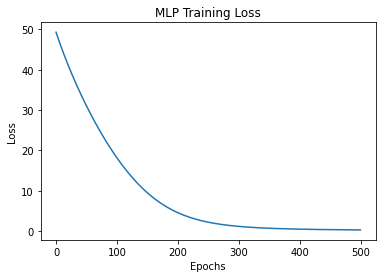

In [51]:


########## Training MLP ##########
loss = []
epochs = 500
CHECKPOINT_PATH = "/content/drive/My Drive/Sp2020/CS522/Final Project/Codes/RNN_long"
model.train(True)
for i in range(epochs):
    running_loss = 0
    for j, data in enumerate(train_inout_seq):
      seq,labels = data

      seq.to(device)
      labels.to(device)
      optimizer.zero_grad()
      y_pred = model(seq)
      y_pred.requires_grad_(True)
      # y_pred = y_pred.reshape((1,y_pred.shape[2]))
      single_loss = loss_function(y_pred, labels)
      single_loss.backward()
      optimizer.step()
      running_loss += single_loss.item() 
    loss.append(running_loss)
    if i%1 == 0:
      print(f'epoch: {i:3} loss: {running_loss:10.3f}')
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('MLP Training Loss')
# plt.ylim((-1,100))
#       if i%25 == 0:
#         torch.save({'model': model,
#                     'loss': loss
#                       }, CHECKPOINT_PATH+".pth")
# print(f'epoch: {i:3} loss: {running_loss:10.10f}')
# torch.save({'model': model,
#             'loss': loss}, CHECKPOINT_PATH+".pth")

In [52]:
print(labels)
print(y_pred)
print()
# print(scaler.inverse_transform(labels))
# print(scaler.inverse_transform(y_pred.detach().numpy()))

tensor([[-0.2380,  1.0000, -0.2430,  1.0000, -0.2423,  1.0000, -0.2521,  1.0000,
         -0.2254,  1.0000, -0.2538,  1.0000, -0.2496,  1.0000, -0.2522,  1.0000,
         -0.2298,  1.0000, -0.2446,  1.0000,  1.0000,  0.1647,  1.0000,  0.1626,
          1.0000,  0.1570,  1.0000,  0.1707,  1.0000,  0.1572,  1.0000,  0.1727,
          1.0000,  0.1683,  1.0000,  0.1642,  1.0000,  0.1639,  1.0000,  0.1708]])
tensor([[-0.3078,  1.0168, -0.1665,  0.9441, -0.2922,  0.9228, -0.3459,  0.9408,
         -0.2973,  0.7448, -0.3020,  0.7636, -0.3536,  0.8265, -0.3675,  0.7444,
         -0.3199,  0.8626, -0.2843,  0.9736,  0.9569,  0.1706,  0.8644,  0.2311,
          0.9643,  0.2144,  0.8873,  0.1367,  0.8880,  0.1678,  0.8733,  0.2581,
          0.9569,  0.2093,  0.9128,  0.2078,  0.7809,  0.3511,  0.8533,  0.2145]],
       grad_fn=<SelectBackward>)



In [53]:
############ MLP Model Testing #############

fut_pred = len(pos_test_data)
#fut_pred = len(pos_train_data)-train_window
test_inputs = train_data_normalized[-train_window:].tolist()
#test_inputs = train_data_normalized[0:train_window].tolist()
# model.eval()
for i in range(fut_pred):
    # print(i)/
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        
        test_inputs.append(model(seq).detach().numpy()[0].tolist())

# only keeps predicted values
# test_inputs = test_inputs[-fut_pred:]
actual_predictions = scaler.inverse_transform(test_inputs)

# discarding velocity information
actual_predictions = actual_predictions[:,0:int(input_size/2)]
actual_predictions = np.reshape(actual_predictions, [fut_pred+train_window,int(input_size/4),2])

# print(len(actual_predictions))
print('last step: ', np.reshape(pos_train_data[len(pos_train_data)-1], [10,2])[0])
print('prediction: ', actual_predictions[0][0])
print('ground truth: ', np.reshape(pos_test_data[0], [10,2])[0])

last step:  [3.80299254 7.3109618 ]
prediction:  [3.33030568 7.18050381]
ground truth:  [3.92490677 7.32853946]


Predicted number of time steps:  405


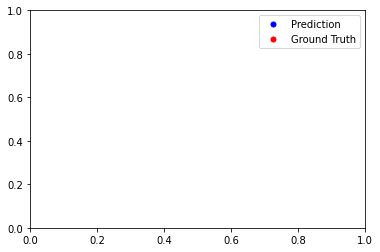

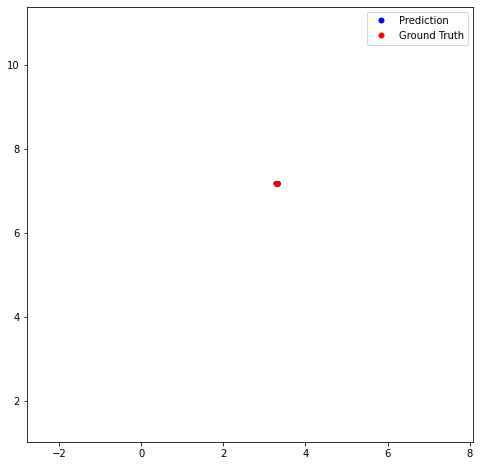

In [57]:
############ REPLAYING FILES ############
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

blue_dot = mlines.Line2D([], [], color='blue', marker='.', linestyle='None',
                          markersize=10, label='Prediction')
red_dot = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                          markersize=10, label='Ground Truth')
plt.legend(handles=[blue_dot, red_dot])

actual_predictions = np.array(actual_predictions)
pred_len = len(actual_predictions+1)
print("Predicted number of time steps: ", pred_len)

#ground_truth = np.reshape(pos_test_data, [len(pos_test_data), 32,2])
gt = np.concatenate((pos_train_data[-train_window:], pos_test_data),axis=0)
ground_truth = np.reshape(gt,  [pred_len, 10,2])

x = actual_predictions[:,:,0]
y = actual_predictions[:,:,1]
x_gt = ground_truth[:,:,0]
y_gt = ground_truth[:,:,1]

# x = gt_recon[:,:,0]
# y = gt_recon[:,:,1]
# x_gt = pred_recon[:,:,0]
# y_gt = pred_recon[:,:,1]

x_min = np.amin(x)-4
x_max = np.amax(x)+4
y_min = np.amin(y)-4
y_max = np.amax(y)+4

fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.axes(xlim=(x_min,x_max),ylim=(y_min,y_max))



# initialize animation parameters
gg = [Line2D([x_gt[0][0], x[0][0]],[y_gt[0][0], y[0][0]]) for i in range(10)]
for j in range(10):
  gg[j], = ax.plot([x_gt[0][j], x[0][j]],[y_gt[0][j], y[0][j]], c='mediumspringgreen',marker='.')
d, = ax.plot(x[0],y[0], c='blue',marker='.',linestyle='None')
e, = ax.plot(x_gt[0],y_gt[0], c='red',marker='.',linestyle='None')

def animate(i):
    plt.legend(handles=[blue_dot, red_dot])
    for j in range(10):
      gg[j].set_data([x_gt[i][j], x[i][j]],[y_gt[i][j], y[i][j]])
    d.set_data(x[i],y[i])
    e.set_data(x_gt[i],y_gt[i])
    return e, d,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=400, interval=1, blit=False)
anim.save('mlp1.mp4',writer=animation.FFMpegWriter(fps=20))
rc('animation', html='jshtml')
anim
